# torch cifar 10

https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
#added augmentation
transform_train = \
                transforms.Compose([\
                transforms.RandomHorizontalFlip(0.5), \
                transforms.RandomGrayscale(0.1),\
                transforms.ToTensor(),\
                transforms.Normalize((0.5, 0.5, 0.5), \
                (0.5, 0.5, 0.5))])
transform_test =\
                transforms.Compose([\
                transforms.ToTensor(),\
                transforms.Normalize((0.5, 0.5, 0.5), \
                (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root='data', train=True,download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='data', train=False,download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#splits
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

In [4]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
dev_sampler = torch.utils.data.SubsetRandomSampler(dev_idx)

In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, \
sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, \
sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## neural net

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(40 * 4 * 4, 100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

In [7]:
model = CNN().to("cuda")
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [8]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []
# For loop through the epochs
for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    model.train()
    """
    For loop through the batches (created using
    the train loader)
    """
    for data, target in train_loader:
        data_cuda = data.cuda()
        target_cuda = target.cuda()
        
        iterations += 1
        # Forward and backward pass of the training data
        pred = model(data_cuda)        
        loss = loss_function(pred, target_cuda)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target_cuda.cpu(), top_class.cpu())
        
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
    
    # Validation of model for given epoch
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        with torch.no_grad():
            model.eval()
            """
            For loop through the batches of
            the validation set
            """
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                data_dev_cuda = data_dev.cuda()
                target_dev_cuda = target_dev.cuda()
                
                dev_pred = model(data_dev_cuda)
                dev_loss = loss_function(dev_pred, target_dev_cuda)
                dev_losss += dev_loss.item()
                dev_p = torch.exp(dev_pred)            
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev_cuda.cpu(), \
                dev_top_class.cpu())
            # Losses and accuracy are appended to be printed
            train_losses.append(losses/iterations)
            dev_losses.append(dev_losss/iter_2)
            train_acc.append(acc/iterations)
            dev_acc.append(dev_accs/iter_2)
            print("Epoch: {}/{}.. ".format(e, epochs), \
                "Training Loss: {:.3f}.. "\
                .format(losses/iterations), \
                "Validation Loss: {:.3f}.. "\
                .format(dev_losss/iter_2), \
                "Training Accuracy: {:.3f}.. "\
                .format(acc/iterations), \
                "Validation Accuracy: {:.3f}"\
                .format(dev_accs/iter_2))

Epoch: 1/100..  Training Loss: 1.754..  Validation Loss: 1.480..  Training Accuracy: 0.354..  Validation Accuracy: 0.460
Epoch: 5/100..  Training Loss: 1.197..  Validation Loss: 1.131..  Training Accuracy: 0.571..  Validation Accuracy: 0.596
Epoch: 10/100..  Training Loss: 1.020..  Validation Loss: 0.955..  Training Accuracy: 0.639..  Validation Accuracy: 0.669
Epoch: 15/100..  Training Loss: 0.925..  Validation Loss: 0.871..  Training Accuracy: 0.673..  Validation Accuracy: 0.696
Epoch: 20/100..  Training Loss: 0.860..  Validation Loss: 0.845..  Training Accuracy: 0.696..  Validation Accuracy: 0.703
Epoch: 25/100..  Training Loss: 0.821..  Validation Loss: 0.799..  Training Accuracy: 0.710..  Validation Accuracy: 0.719
Epoch: 30/100..  Training Loss: 0.788..  Validation Loss: 0.789..  Training Accuracy: 0.722..  Validation Accuracy: 0.724
Epoch: 35/100..  Training Loss: 0.763..  Validation Loss: 0.768..  Training Accuracy: 0.729..  Validation Accuracy: 0.731
Epoch: 40/100..  Training 

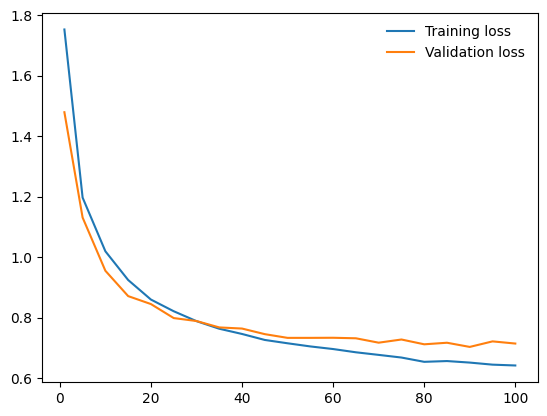

In [9]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

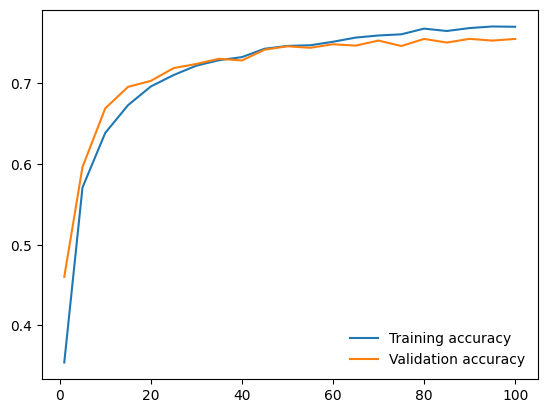

In [10]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [11]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    data_test_cuda = data_test.cuda()
    target_test_cuda = target_test.cuda()
    
    iter_3 += 1
    test_pred = model(data_test_cuda)
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test_cuda.cpu(), top_class_test.cpu())
print(acc_test/iter_3)

0.7539999999999999


In [12]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomGrayscale(p=0.1)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )